# Free curling 
-  Ionic polymer-metal composites

- Curling of an ipmc beam
- This is a two-dimensional plane-strain simulation

# Degrees of freedom
- Displacement: u
- Species concentration: c
- Electrostatic potential: phi

# Units
- Length: mm
- Mass: tonne (1000 kg)
- Time: s
- Amount of substance: mol
- Electric charge: mC
- Temperature: K

- Force: N
- Energy: mJ
- Stress: MPa 

- Species concentration: mol/mm^3
- Molar volume: mm^3/mol
- Species diffusivity: mm^2/s

 
- Electric potential: V (=mJ/mC)
- Permittivity: mF/mm 
- Permittivity of free space = 8.85e-12 mF/mm
- Faraday's constant: 96.485e6 mC/mol
- Gas constant: 8.3145e3 mJ/(mol K)

### Software:
- Dolfinx v0.8.0

In the collection "Example Codes for Coupled Theories in Solid Mechanics,"

By Eric M. Stewart, Shawn A. Chester, and Lallit Anand.

https://solidmechanicscoupledtheories.github.io/



# Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile

# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 lt, gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh,\
                 cosh, atan, atan2)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime

# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [2]:
# We will first create a unit square mesh and then map it
# to create a graded mesh in the y-direction, which is refined towards its top and bottom edges.
# Finally we will map it to represent a beam of length 20mm and height 0.3 mm.

# Number of elements along the length (20 is fast, 100 is reasonable)
lElem = 100

# 2N number of elements in y-direction                                             
N = 60

domain = mesh.create_rectangle(MPI.COMM_WORLD, [[0,0], [1,1]],\
                [lElem, 2*N], mesh.CellType.triangle, diagonal=mesh.DiagonalType.crossed)

# Map the coordinates of the uniform square mesh to the biased spacing
# Be careful here, even though it is 2-D simulation xthe quantity Orig  stores 3-D coordinates, 
# so XMap should also be  appropriately dimensioned.
#
# First get the mesh coordinates x for mapping
xOrig = domain.geometry.x   
# create and empty xMap to stored the results from the mapping
xMap  = np.zeros((len(xOrig),3))  

# Perform the mapping to create a biased mesh. This is needed to resolve the electric double layers
# The parameter r is bias successive mesh spacing ratio in the vertical direction; it should be less than 1    
r = 1/1.09  
a = (1-r)/(1-r**N)   

# Re-scale the y-coordinate so that it ranges from (-1, 1)
xMap[:,1] = xOrig[:,1]*2 - 1

# Bias the y-coordinate
xMap[:,1] = np.sign(xMap[:,1])*a*(r**(np.abs(xMap[:,1])*N)-1)/(r-1)

# Scale the whole thing to the desired dimensions
#
scaleX = 20.e0 # length of beam
scaleY = 0.3e0 # height of beam
#
xMap[:,0] = xOrig[:,0]*scaleX
xMap[:,1] = xMap[: ,1]*scaleY/2


# Uppdate the mesh coordinates
domain.geometry.x[:] = xMap

# This says "spatial coordinates" but is really the referential coordinates,
# since the mesh does not convect in FEniCS
x = ufl.SpatialCoordinate(domain)

**Identify boundaries of the domain**

In [3]:
# Identify the boundaries of the  rectangle mesh
#
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], scaleX)
def yBot(x):
    return np.isclose(x[1], - scaleY/2) 
def yTop(x):
    return np.isclose(x[1],   scaleY/2)

# Mark the sub-domains
boundaries = [(1, xBot),(2, xTop), (3, yBot), (4, yTop)]

# Build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Print out the unique facet index numbers**

In [4]:
top_imap = domain.topology.index_map(1)      # index map of 1D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique 

# Mark the sub-domains
# boundaries = [(1, xBot),(2, xTop),(3, yBot),(4, yTop)]

[1 2 3 4]


**Visualize reference configuration**

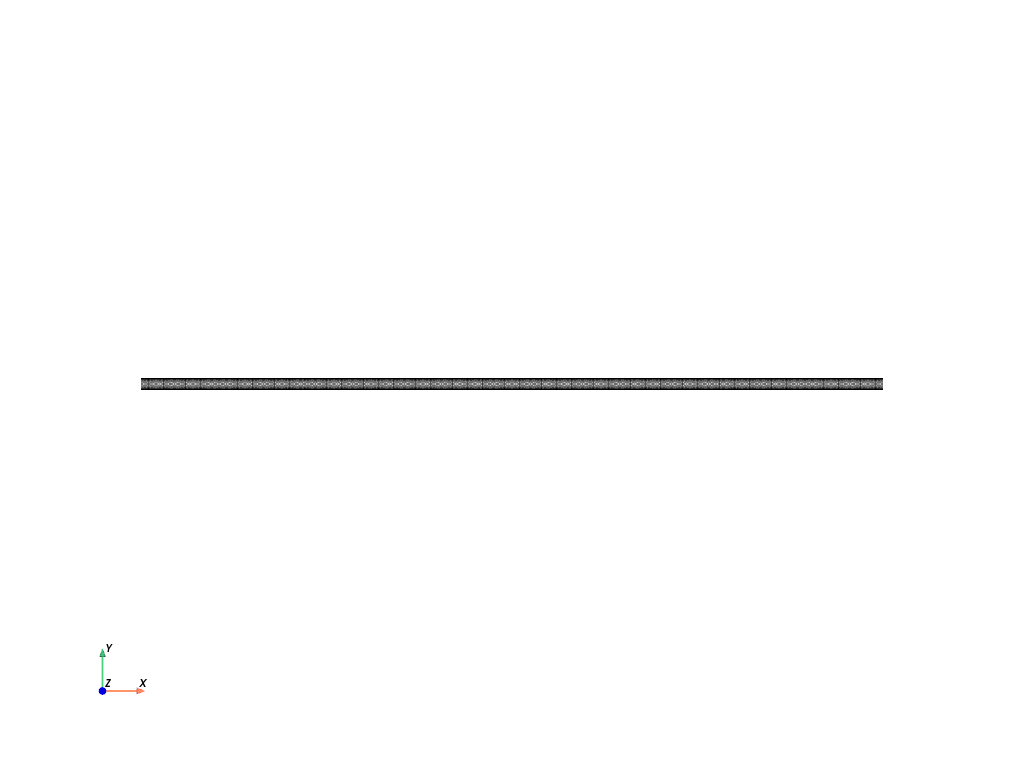

In [5]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True, opacity=0.25) 


plotter.view_xy()

#labels = dict(xlabel='X', ylabel='Y',zlabel='Z')
labels = dict(xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

plotter.screenshot("results/ipmc_beam_mesh.png")

from IPython.display import Image
Image(filename='results/ipmc_beam_mesh.png') 

# # Use the following  commands for a  zoom-able  view
# if not pyvista.OFF_SCREEN:
#     plotter.show()
# else:
#     plotter.screenshot("ipmc_beam_mesh.png")

## Define boundary and volume integration measure

In [6]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':2})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 2})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

# #  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([n2D[0], n2D[1], 0.0]) # define n as a 3D vector for later use

# Material parmeters

In [7]:
# Mechanics
#
Young  =  Constant(domain,PETSc.ScalarType(100))                # Young's modulus, MPa
Nu     =  Constant(domain,PETSc.ScalarType(0.4))                # Poisson's ratio
Gshear =  Constant(domain,PETSc.ScalarType(Young/(2*(1+Nu))))   # Shear modulus, Mpa
Kbulk  =  Constant(domain,PETSc.ScalarType(Young/(3*(1-2*Nu)))) # Bulk modulus, MPa

# Chemistry
Omega =  Constant(domain,PETSc.ScalarType(1.0e5))                  # solvated cation molecular volume, mm^3/mol
D     =  Constant(domain,PETSc.ScalarType(1.3e-5) )                # Diffusivity, mm^2/s
RT    =  Constant(domain,PETSc.ScalarType(8.3145e3*(273.0+25.0)))  # Gas constant*Temp
c_R0  =  Constant(domain,PETSc.ScalarType(1500*1e-9))              # Initial  concentration 
cMax  =  Constant(domain,PETSc.ScalarType(4750*1e-9))              # Saturation concentration, mol/mm^3
c0    =  Constant(domain,PETSc.ScalarType(c_R0/cMax))              # Initial cnormalized concentration

# Electrostatics
vareps0    =  Constant(domain,PETSc.ScalarType(8.85e-12))         # Vacuum permittivity, mF/mm
vareps_r   =  Constant(domain,PETSc.ScalarType(50))               # Relative permittivity of polymer
vareps_num =  Constant(domain,PETSc.ScalarType( 2.5*1.0e7 )) # Numerical permittivity factor
Farad      =  Constant(domain,PETSc.ScalarType( 96.485e6 ))       # Faraday constant, uC/mol  

# Simulation time-control related parameters

In [8]:
t    = 0.0   # initialization of time
Ttot = 20.0  # total simulation time 
ttd  = 0.2   # Decay time for increasing voltage
dt   = 0.1  # Time step size, s

# Time step field, constant within body
dk = Constant(domain, PETSc.ScalarType(dt))

# Maximum applied voltage, V
phi_BC = 3.0  

# Boundary condition expression for increasing  the voltage
#
def phiRamp(t):
    return phi_BC*(1-exp(-t/ttd))

# Function spaces

In [9]:
# Define function spaces
# 
U2 = element("Lagrange", domain.basix_cell(), 2, shape=(2,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1)             # For species concentration and electric potential
#                                      
TH = mixed_element([U2, P1, P1])  # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs

# Define actual functions with the required DOFs
w = Function(ME)
u, c, phi = split(w)  # displacement u, concentration c, voltage phi

# A copy of functions to store values in the previous step for time-stepping
w_old = Function(ME)
u_old, c_old, phi_old = split(w_old)   

# Define test functions    
u_test, c_test, phi_test = TestFunctions(ME)  

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)                  

# Initial conditions

- The initial conditions for degrees of freedom $\mathbf{u}$ and $\phi$ are zero everywhere.
- These are imposed automatically, since we have not specified any non-zero initial conditions.
- We do, however, need to impose the uniform initial condition $\bar{c} = \bar{c}_0$. This is done below.

In [10]:
# Assign initial  value of c0, the normalized concentration, to the domain
#
w.sub(1).interpolate(lambda x: np.full((x.shape[1],),  c0))
w_old.sub(1).interpolate(lambda x: np.full((x.shape[1],), c0))    

# Subroutines for kinematics and constitutive equations

In [11]:
# Special gradient operators for plane strain 
#
# Gradient of vector field u   
def pe_grad_vector(u):
    
    grad_u = grad(u)
    
    pe_grad_u = ufl.as_tensor([ [grad_u[0,0], grad_u[0,1], 0.0],
                                [grad_u[1,0], grad_u[1,1], 0.0],
                                [        0.0,         0.0, 0.0] ]) 
    return pe_grad_u

# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
def pe_grad_scalar(y):
    
    grad_y = grad(y)
    
    pe_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.0])
    
    return pe_grad_y

# Plane strain deformation gradient 
def F_pe_calc(u):
    
    dim = len(u)                # dimension of problem (2)
    
    Id = Identity(dim)          # 2D Identity tensor
    
    F = Id + grad(u)            # 2D Deformation gradient
      
    F_pe =  ufl.as_tensor([ [F[0,0], F[0,1], 0.0],
                            [F[1,0], F[1,1], 0.0],
                            [   0.0,    0.0, 1.0] ]) # Full plane strain F
    return F_pe


def Piola_mech_calc(F, c):
    Id = Identity(3)
    
    # Elastic volumetric strain
    Js = 1 + Omega*cMax*(c-c0) 
    Je = J/Js              
    #
    Fs = Js**(1/3)*Id
    Fe = F*inv(Fs)
    Be = Fe*Fe.T
    #
    Bebar = Je**(-2/3)*Be
    #
    Piola_mech = Js*(Gshear*(Bebar - (1/3)*tr(Bebar)*Id) + Kbulk*(Je-1)*Id)*inv(F.T) 
    #
    return Piola_mech

def p_tilde_calc(F, c):
    #
    # Elastic volumetric strain
    Js = 1 + Omega*cMax*(c-c0) 
    Je = J/Js  
    #
    p_tilde = -Kbulk*(Je-1.0)
    #
    return p_tilde
    
def Piola_maxw_calc(F, phi):
    e_R     = - pe_grad_scalar(phi)
    e_sp    = inv(F.T)*e_R
    T_max   = vareps0*vareps_r*(outer(e_sp,e_sp) - (1/2)*(inner(e_sp,e_sp))*Identity(3))
    Piola_max = J*T_max*inv(F.T)
    return Piola_max

def flux_calc(u, c, phi, press):
    #
    F  = F_pe_calc(u)
    J  = det(F)  # Total volumetric jacobian
    Ci = inv(F.T*F)
    #
    Jmat = - D * Ci *( pe_grad_scalar(cMax*c) \
                    + (Omega*cMax*c*(1-c)/RT)*pe_grad_scalar(press) \
                    + (Farad*cMax*c*(1-c)/RT)*pe_grad_scalar(phi) )   
    #
    return Jmat

def dmat_calc(F, phi):
    dmat = - vareps0*vareps_r*vareps_num*Ci*pe_grad_scalar(phi)
    return dmat

# Evaluate kinematics and constitutive relations

In [12]:
# Kinematics
F  = F_pe_calc(u)
J  = det(F)  # Total volumetric jacobian
Js = 1 + Omega*cMax*(c - c0) 
Ci = inv(F.T*F) # Inverse of the right Cauchy-Green strain tensor

# Compute the stress, pressure for echem. pot.
Piola_mech = Piola_mech_calc(F, c)  
Piola_max  = Piola_maxw_calc(F, phi)
Piola      = Piola_mech + Piola_max
#
# Compute the mechanical pressure which drives species flux
press = p_tilde_calc(F, c) 

# referential flux of mobile species
jmat = flux_calc(u, c, phi, press)

# referential electric displacement
dmat = dmat_calc(F, phi)

# Weak forms

In [13]:
# The weak form for the equilibrium equation
# Test fxn: u
Res_0 = inner(1/Gshear*Piola,pe_grad_vector(u_test))*dx

# The weak form for the mass balance 
# Test fxn: c_test
Res_1 = dot((c-c_old)/dk,c_test)*dx \
    - (1/cMax)*dot(jmat,pe_grad_scalar(c_test))*dx    
         
# The weak form for Gauss' Law
# Test fxn: phi
Res_2 = dot(dmat,pe_grad_scalar(phi_test))*dx \
     +inner(Farad*cMax*(c-c0),phi_test)*dx  
     
# Total weak form
Res = Res_0 + Res_1 + Res_2  

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [14]:
# results file name
results_name = "ipmc_transient_curl"

# Function space for projection of results
U1 = element("DG", domain.basix_cell(), 1, shape=(2,))  # For displacement
P0 = element("DG", domain.basix_cell(), 1)              # For concentration  and electric potential
T1 = element("DG", domain.basix_cell(), 1, shape=(3,3)) # For stress tensor

V1 = fem.functionspace(domain, P0) # Scalar function space
V2 = fem.functionspace(domain, U1) # Vector function space
V3 = fem.functionspace(domain, T1) # Tensor function space

# basic fields to write to output file
u_vis = Function(V2)
u_vis.name = "disp"

c_vis = Function(V1)
c_vis.name = "c"

phi_vis = Function(V1)
phi_vis.name = "phi"

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Piola[0,0],V1.element.interpolation_points())
#
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Piola[1,1],V1.element.interpolation_points())
#
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Piola[2,2],V1.element.interpolation_points())

# Mises stress
T          = Piola*F.T/J
T0         = T - (1/3)*tr(T)*Identity(3)
Mises      = sqrt((3/2)*inner(T0, T0))
Mises_vis  = Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, c_vis, phi_vis, P11, P22, P33,Mises_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       # Output field interpolation 
       u_vis.interpolate(w.sub(0))
       c_vis.interpolate(w.sub(1))
       phi_vis.interpolate(w.sub(2))
       P11.interpolate(P11_expr)
       P22.interpolate(P22_expr)
       P33.interpolate(P33_expr)
       Mises_vis.interpolate(Mises_expr)

       # Write output fields
       file_results.write(t) 
        

# Infrastructure for pulling out time history data (dislacement, force, etc.)

In [15]:
# Identify point for reporting potential and dispalcement
pointForDisp = np.array([scaleX,scaleY/2,0.0])


bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForDisp)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDisp).array


# Analysis Step

In [16]:
# Give the step a descriptive name
step = "Curl"

## Boundary conditions

In [17]:
# Sub-domain markers
# boundaries = [(1, xBot),(2, xTop),(3, yBot),(4, yTop)]

# Constant for applied  electric potential
phi_cons = Constant(domain,PETSc.ScalarType(phiRamp(0)))

# Find the specific DOFs which will be constrained.
xBot_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1))
xBot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(1))
#
yBot_phi_dofs= fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(3))
yTop_phi_dofs= fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(4))

# Building Dirichlet BCs
bcs_1 = dirichletbc(0.0, xBot_u1_dofs, ME.sub(0).sub(0))   # u1 fix xBot
bcs_2 = dirichletbc(0.0, xBot_u2_dofs, ME.sub(0).sub(1))   # u2 fix xBot
#
bcs_3 = dirichletbc(0.0,      yBot_phi_dofs, ME.sub(2))    # phi =0 yBot
bcs_4 = dirichletbc(phi_cons, yTop_phi_dofs, ME.sub(2))    # phi= mphi_cons- yTop

bcs = [bcs_1, bcs_2, bcs_3, bcs_4]


## Define the nonlinear variational problem

In [18]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# The global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"  
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

# Initialize arrays for storing output history

In [19]:
# Arrays for storing output history
totSteps = 100000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps]) 
# timeHist3 = np.zeros(shape=[totSteps])

# Initialize a counter for reporting data
ii = 0

# Write initial state to file
writeResults(t=0.0) 

##  Start calculation loop

In [20]:
# Print  message for simulation start
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    phi_cons.value = float(phiRamp(t))
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print("Ended Early")
        break
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Write output to file
    writeResults(t)
    
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
    
    
    # Store  displacement at a particular point  at this time
    #
    timeHist0[ii] = t      
    #
    timeHist1[ii] = w.sub(2).eval([scaleX,scaleY/2,0.0],colliding_cells[0])[0]        # time history of voltage (phi)# time
    #
    timeHist2[ii] = w.sub(0).sub(1).eval([scaleX,scaleY/2,0.0],colliding_cells[0])[0] # time history of tip displacement

   
    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Increment: {}, Iterations: {}".\
              format(step, ii, iter))
        print("      Simulation Time: {} s  of  {} s".\
              format(round(t,4), Ttot))
        print()  
    
# close the output file.
file_results.close()
  
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Curl | Increment: 1, Iterations: 5
      Simulation Time: 0.1 s  of  20.0 s

Step: Curl | Increment: 2, Iterations: 5
      Simulation Time: 0.2 s  of  20.0 s

Step: Curl | Increment: 3, Iterations: 6
      Simulation Time: 0.3 s  of  20.0 s

Step: Curl | Increment: 4, Iterations: 6
      Simulation Time: 0.4 s  of  20.0 s

Step: Curl | Increment: 5, Iterations: 6
      Simulation Time: 0.5 s  of  20.0 s

Step: Curl | Increment: 6, Iterations: 6
      Simulation Time: 0.6 s  of  20.0 s

Step: Curl | Increment: 7, Iterations: 6
      Simulation Time: 0.7 s  of  20.0 s

Step: Curl | Increment: 8, Iterations: 6
      Simulation Time: 0.8 s  of  20.0 s

Step: Curl | Increment: 9, Iterations: 6
      Simulation Time: 0.9 s  of  20.0 s

Step: Curl | Increment: 10, Iterations: 6
      Simulation Time: 1.0 s  of  20.0 s

Step: Curl | Increment: 11, Iterations: 6
      Simulation Time: 1.1 s  of  20

# Plot results

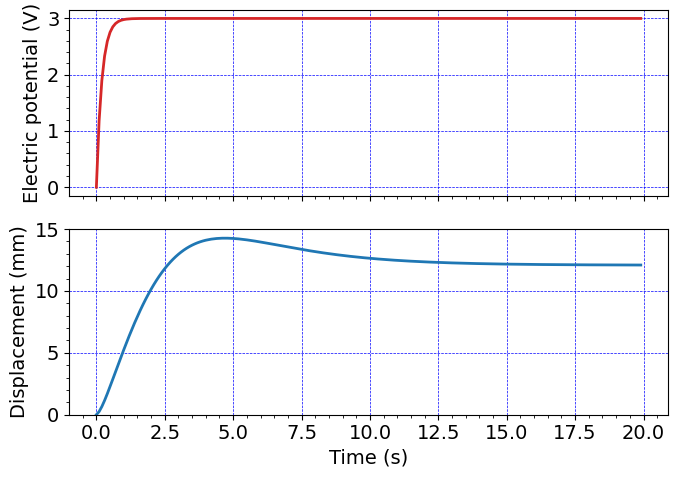

In [21]:
# Set up font size, initialize colors array
font = {'size'   : 14}
plt.rc('font', **font)
#
prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

# Only plot as far as we have time history data
ind = np.argmax(timeHist0[:])

# Two-axis plotting
fig, (ax1, ax2) = plt.subplots(2,1, sharex='col')

#---------------------------------------------
ax1.plot(timeHist0[0:ind], timeHist1[0:ind], c=colors[3], linewidth=2.0)
ax1.grid(linestyle="--", linewidth=0.5, color='b')
ax1.set_ylabel('Electric potential (V)')
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
#-----------------------------------------------
ax2.plot(timeHist0[0:ind], timeHist2[0:ind], c=colors[0], linewidth=2.0)
ax2.grid(linestyle="--", linewidth=0.5, color='b')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Displacement (mm)')
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.set_ylim([0,15])
#-----------------------------------------------
#plt.show()

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/ipmc_beam_curling.png", dpi=600)


## Plotting the concentration profile along the beam height

In [22]:
# Collapse the concentration subspace:
V_C, _ = ME.sub(1).collapse() 

# Identify concentration DOFs along desired plotting  path which is xTop (index 2)  --- the right face of the beam
#
right_C_dofs = fem.locate_dofs_topological((ME.sub(1), V_C), facet_tags.dim, facet_tags.find(2))[1]

# Locate the  y coordinates along the path
# 
yPath = V_C.tabulate_dof_coordinates()[right_C_dofs, 1]  

# Store the values of the concentration along the path
C_out = w.sub(1).collapse()
C_out.name = "Concentration"
#
cProfile = C_out.vector.array[right_C_dofs]


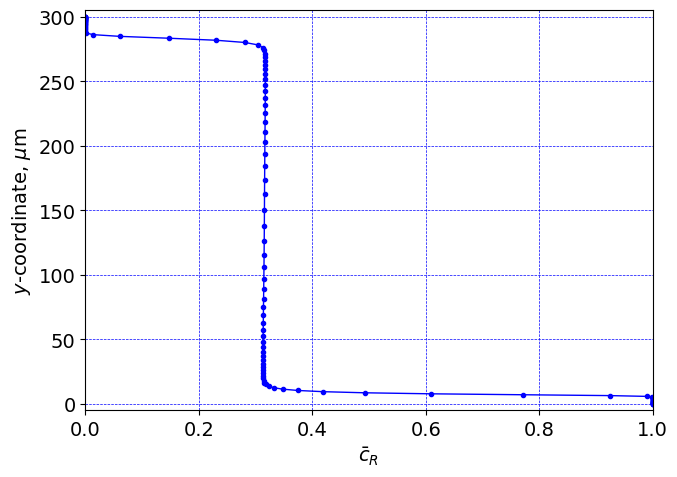

In [23]:
# set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Plot the concentration profile
fig = plt.figure()
plt.plot(cProfile, (yPath + scaleY/2)*1e3, c='b', linewidth=1.0, marker='.')
ax = fig.gca()
ax.grid(linestyle="--", linewidth=0.5, color='b')
plt.ylim(-5, 305)
plt.xlim(0, 1.0)
plt.ylabel(r"$y$-coordinate, $\mu$m")
plt.xlabel(r"$\bar{c}_{R}$")

# save the plot
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/IPMC_beam_concentration_profile.png", dpi=600)
